https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/

In [278]:
!pip install yfinance

In [279]:
# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt

# yahoo finance is used to fetch data
import yfinance as yf

from scipy.ndimage import gaussian_filter

In [280]:
ticker = "farm"

[*********************100%***********************]  1 of 1 completed


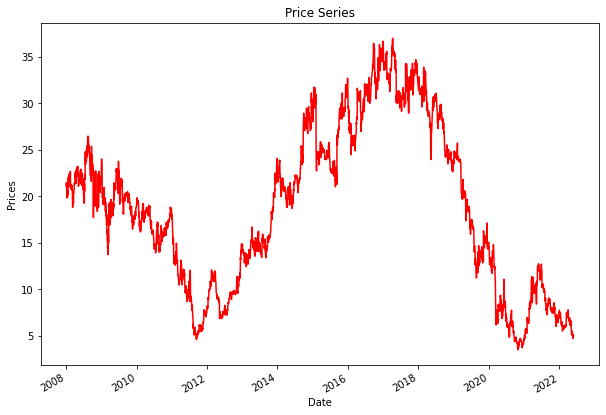

In [281]:
# Read data
df = yf.download(ticker, '2008-01-01', '2022-6-01', auto_adjust=True)
#Convert to log scale
#df = np.log(df)
# Only keep close columns
df = df[['Close']]
# Drop rows with missing values
Df = df.dropna()
# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Prices")
plt.title("Price Series")
plt.show()

In [282]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
#Gausian Filter
Df["GF"] = gaussian_filter((Df["Close"]), sigma=1)
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9', "GF"]]

# Define dependent variable
y = Df['next_day_price']

In [283]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [284]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [285]:
# Training classifiers
#reg1 = GradientBoostingRegressor()
#reg2 = RandomForestRegressor(random_state=0)
linear = LinearRegression()
#linear = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
linear = linear.fit(X_train, y_train)

print("Linear Regression model")
print("BTC Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f * Galois Field (gf) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2], linear.intercept_))

Linear Regression model
BTC Price (y) = -1.26 * 3 Days Moving Average (x1) + 0.11 * 9 Days Moving Average (x2) + 2.15 * Galois Field (gf) + 0.00 (constant)


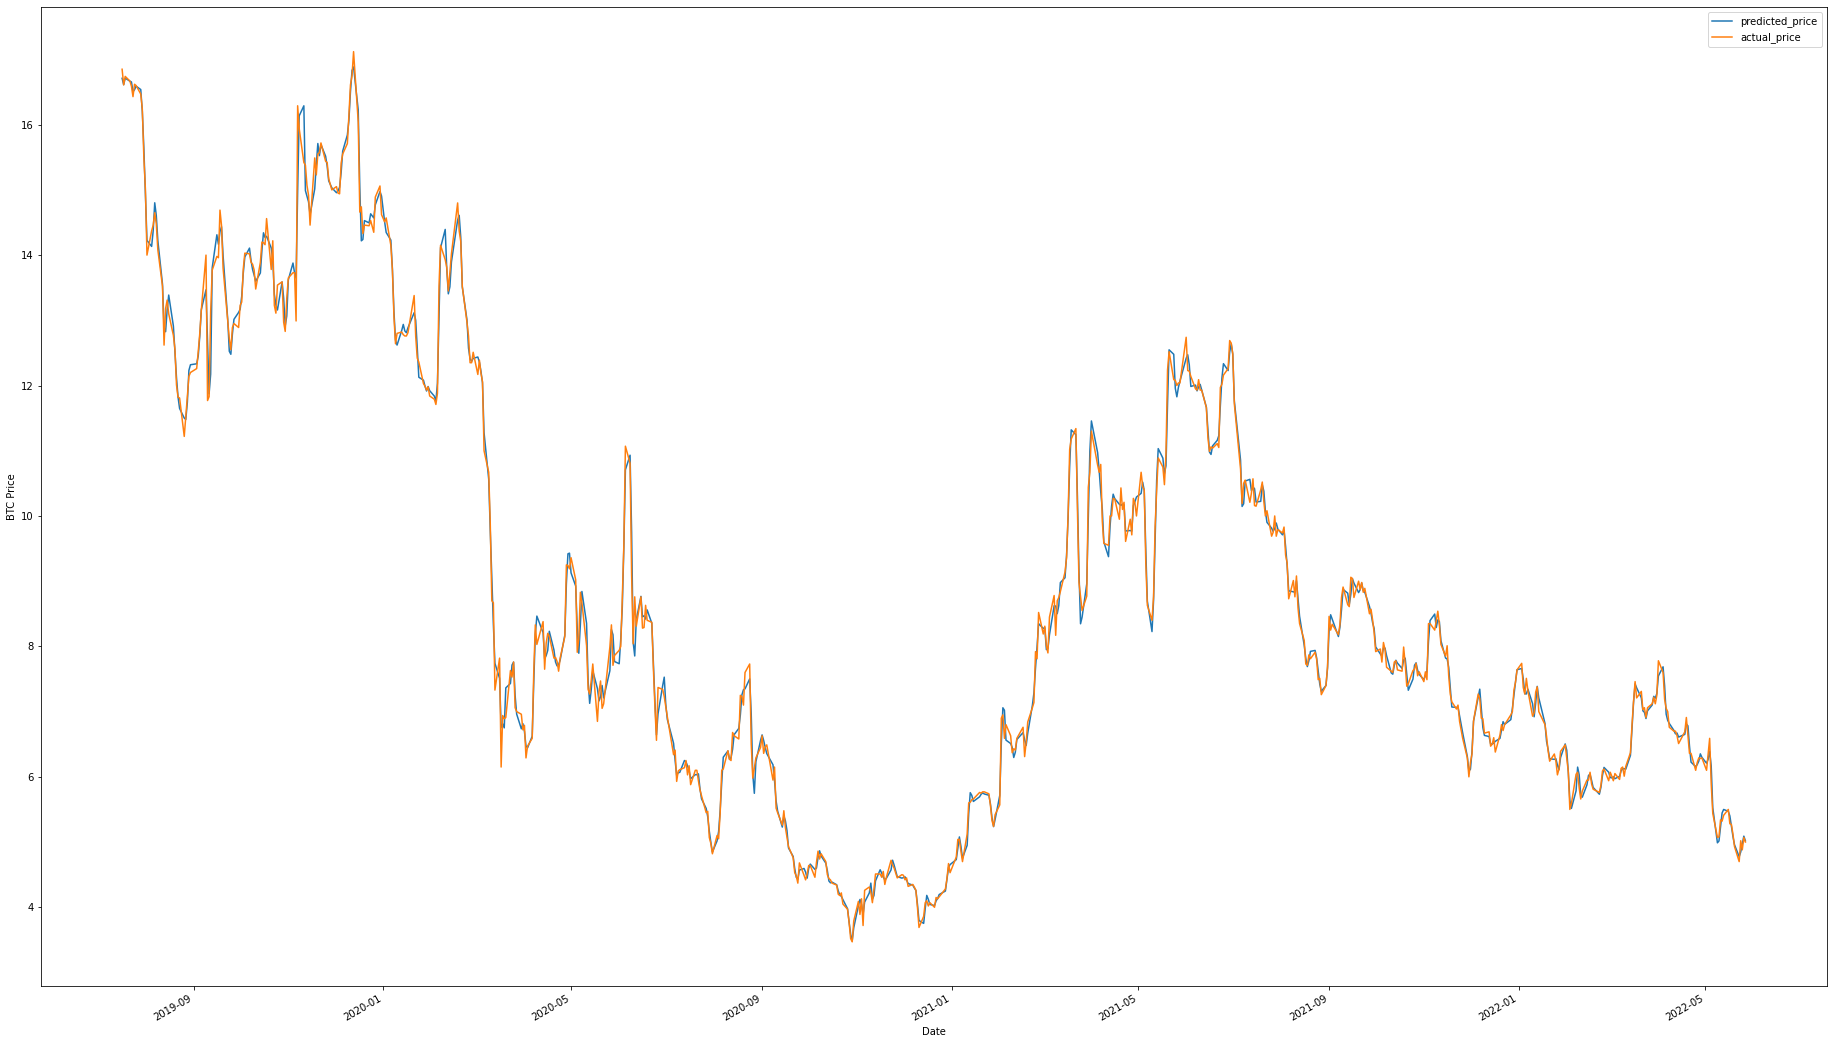

In [286]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(32, 20))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("BTC Price")
plt.show()

In [287]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

99.72

In [288]:
# MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, predicted_price)
float("{0:.2f}".format(mape))

0.01

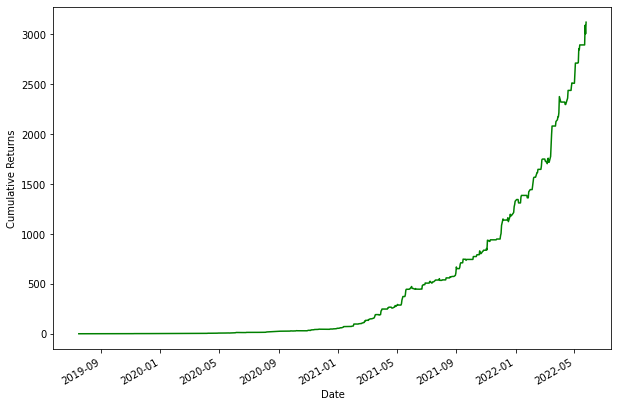

In [289]:
btc = pd.DataFrame()

btc['price'] = Df[t:]['Close']
btc['predicted_price_next_day'] = predicted_price
btc['actual_price_next_day'] = y_test
btc['btc_returns'] = btc['price'].pct_change().shift(-1)

btc['signal'] = np.where(btc.predicted_price_next_day.shift(1) < btc.predicted_price_next_day,1,0)

btc['strategy_returns'] = btc.signal * btc['btc_returns']
((btc['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [290]:
# Calculate sharpe ratio
sharpe = btc['strategy_returns'].mean()/btc['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 5.91'

In [291]:
#Only linear regression: r^2 = 96.74, sharpe = 0.81
#
#
#

In [292]:
# import datetime and get today's date
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download(ticker, '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
#Gausian Filter
data["GF"] = gaussian_filter((data["Close"]), sigma=1)
data = data.dropna()

# Forecast the price
data['predicted_price'] = linear.predict(data[['S_3', 'S_9', "GF"]])
data['signal'] = np.where(data.predicted_price.shift(1) < data.predicted_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_price']].T

[*********************100%***********************]  1 of 1 completed


<ipython-input-292-999b14aa2b0a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_price'] = linear.predict(data[['S_3', 'S_9', "GF"]])
<ipython-input-292-999b14aa2b0a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = np.where(data.predicted_price.shift(1) < data.predicted_price,"Buy","No Position")


Date,2023-02-16
signal,No Position
predicted_price,4.316477
